In [1]:
from utils.gaussian_viewing_utils import * 
import matplotlib.pyplot as plt
import os
from moviepy.editor import ImageSequenceClip
from gaussian_renderer import render, GaussianModel
from scene.cameras import Camera as GSCamera
import kaolin
import time

def log_tensor(t, name, **kwargs):
    print(kaolin.utils.testing.tensor_info(t, name=name, **kwargs))

In [2]:
model_path = '/raid/scratch_not_backed_up/sbonilla/gaussian_ready_c3v4/output/f8df57c9-c'

# Number of views
num_views = 140

# Camera ID
novel_view_camera_id = 3   

# Mask visualization output
output_path = '/home/sbonilla/gaussian-splatting/output/f8df57c9-c/visualization/scaling-masks.mp4'

# Novel view visualization output
nv_output_path = f'/raid/scratch_not_backed_up/sbonilla/gaussian_ready_c3v4/output/f8df57c9-c/visualization/novel-views-around-camera-id{novel_view_camera_id}.mp4'

In [3]:
class PipelineParamsNoparse:
    """ Same as PipelineParams but without argument parser. """
    def __init__(self):
        self.convert_SHs_python = False
        self.compute_cov3D_python = False                      
        self.debug = False

        
def load_checkpoint(model_path, sh_degree=3, iteration=-1):
    # Find checkpoint
    checkpt_dir = os.path.join(model_path, "point_cloud")
    if iteration == -1:
        iteration = searchForMaxIteration(checkpt_dir)
    checkpt_path = os.path.join(checkpt_dir, f"iteration_{iteration}", "point_cloud.ply")
    
    # Load guassians
    gaussians = GaussianModel(sh_degree)
    gaussians.load_ply(checkpt_path)                                                 
    return gaussians


def try_load_camera(model_path, idx=0):
    """ Load one of the default cameras for the scene. """
    cam_path = os.path.join(model_path, 'cameras.json')
    if not os.path.exists(cam_path):
        print(f'Could not find saved cameras for the scene at {cam_path}; using default for ficus.')
        return GSCamera(colmap_id=0,
                        R=np.array([[-9.9037e-01,  2.3305e-02, -1.3640e-01], [ 1.3838e-01,  1.6679e-01, -9.7623e-01], [-1.6444e-09, -9.8571e-01, -1.6841e-01]]), 
                        T=np.array([6.8159e-09, 2.0721e-10, 4.03112e+00]), 
                        FoVx=0.69111120, FoVy=0.69111120, 
                        image=torch.zeros((3, 800, 800)),  # fake 
                        gt_alpha_mask=None, image_name='fake', uid=0)
        
    with open(cam_path) as f:
        data = json.load(f)
        raw_camera = data[idx]
        
    tmp = np.zeros((4, 4))
    tmp[:3, :3] = raw_camera['rotation']
    tmp[:3, 3] = raw_camera['position']
    tmp[3, 3] = 1
    name = raw_camera['img_name']
    C2W = np.linalg.inv(tmp)
    R = C2W[:3, :3].transpose()
    T = C2W[:3, 3]
    width = raw_camera['width']
    height = raw_camera['height']
    fovx = focal2fov(raw_camera['fx'], width)
    fovy = focal2fov(raw_camera['fy'], height)
    return GSCamera(colmap_id=0,
                    R=R, T=T, FoVx=fovx, FoVy=fovy, 
                    image=torch.zeros((3, height, width)),  # fake 
                    gt_alpha_mask=None, image_name=name, uid=0)

def load_camera_map(camera_file, name_convention='id.png'):
    with open(camera_file, 'r') as f:
        data = json.load(f)
    if name_convention == 'id.png':
        return {int(cam['img_name']): cam['id'] for cam in data}
    elif name_convention == 'id_color.jpg':
        return {int(cam['img_name'].split('_')[0]): cam['id_color'] for cam in data}
    else:
        raise ValueError('name_convention not recognized')

gaussians = load_checkpoint(model_path)
pipeline = PipelineParamsNoparse()
background = torch.tensor([0, 0, 0], dtype=torch.float32, device="cuda")
center_camera = try_load_camera(model_path, idx=novel_view_camera_id)

In [4]:
gaussians._xyz.shape[0]

152096

In [5]:
!export CUDA_VISIBLE_DEVICES=3

In [6]:
all_normals = gaussians.compute_point_cloud_normals()

Computing point cloud normals... This will only be done once.



Computing normals: 100%|██████████| 301/301 [00:03<00:00, 87.84it/s] 

Finished computing normals in 3.4325311183929443 seconds.


In [7]:
all_normals[1000]

tensor([ 47.9052,  15.5702, -49.6117,  -0.1459,   0.9556,  -0.2560],
       device='cuda:0', grad_fn=<SelectBackward0>)

In [8]:
gaussian_normals = gaussians.get_gaussian_normals()
gaussian_normals[1000]

tensor([ 47.9052,  15.5702, -49.6117,   0.5976,  -0.1927,   0.7783],
       device='cuda:0', grad_fn=<SelectBackward0>)

In [9]:
from train import compute_geometric_loss

In [10]:
start = time.time()
loss = compute_geometric_loss(gaussian_normals, all_normals)
end = time.time()
print(end - start)

1.1511852741241455


In [11]:
loss

tensor(0.0005, device='cuda:0', grad_fn=<DivBackward0>)

In [16]:
# time the following steps 
import time
import gc
start = time.time()

xyz = gaussians._xyz

# break points up into batches
chunk_size = 500

all_normals = None

for i in range(0, xyz.shape[0], chunk_size):
    chunk = xyz[i:i+chunk_size]

    distances = torch.cdist(chunk, xyz)

    # Find the indices of the k nearest neighbors for each point in the chunk
    k_neighbors_indices = torch.topk(distances, k=10+1, largest=False, sorted=False)[1][:, 1:]

    # Flatten the indices
    flat_indices = k_neighbors_indices.reshape(-1)

    selected_neighbors = torch.index_select(xyz, 0, flat_indices)

    actual_chunk_size = chunk.shape[0]

    neighbors = torch.index_select(xyz, 0, flat_indices).reshape(actual_chunk_size, 10, xyz.shape[1])

    neighbors_centered = neighbors - neighbors.mean(dim=2, keepdim=True)

    covariance_matrices = torch.matmul(neighbors_centered.transpose(-2, -1), neighbors_centered) / (10 - 1)

    _, eigenvectors = torch.linalg.eigh(covariance_matrices)

    normals = eigenvectors[..., 0]

    normals_normalized = torch.nn.functional.normalize(normals, dim=-1)

    if all_normals is None:
        all_normals = normals_normalized
    else:
        all_normals = torch.cat((all_normals, normals_normalized), dim=0)

    del chunk, k_neighbors_indices, neighbors, neighbors_centered, covariance_matrices, eigenvectors, normals
    gc.collect()

# end time
end = time.time()

# print
print(f'Time elapsed: {end - start}')

Time elapsed: 23.751441955566406


In [17]:
all_normals.shape

torch.Size([152096, 3])

In [15]:
eigenvalues, eigenvectors = torch.linalg.eigh(gaussians.get_actual_covariance())
normal_vector = eigenvectors[:, :, 0]
normalize_normal =  torch.nn.functional.normalize(normal_vector, dim=1) 
print(eigenvalues[0])
print(eigenvectors[0])
print(normal_vector[0])
print(normalize_normal[0])

tensor([0.0264, 0.0751, 2.4971], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([[-0.3464,  0.0966,  0.9331],
        [ 0.9319, -0.0782,  0.3541],
        [ 0.1072,  0.9922, -0.0629]], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor([-0.3464,  0.9319,  0.1072], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([-0.3464,  0.9319,  0.1072], device='cuda:0', grad_fn=<SelectBackward0>)


In [4]:
!nvidia-smi

Thu Nov 30 15:09:33 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:07:00.0 Off |                    0 |
| N/A   31C    P0    59W / 400W |  24758MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100-SXM...  Off  | 00000000:0F:00.0 Off |                    0 |
| N/A   

In [5]:
!export CUDA_VISIBLE_DEVICES=6

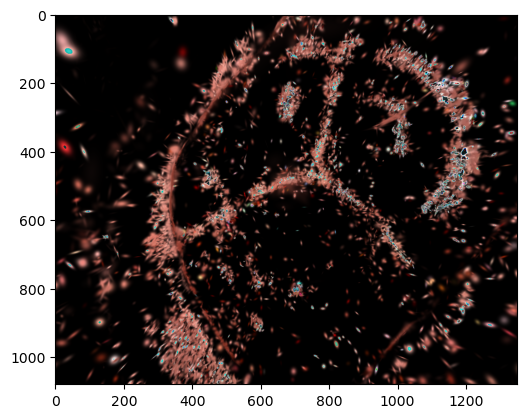

In [6]:
img_array = render_mask_gaussians(model_path, percent_of_gaussians=0.6, camera_index=novel_view_camera_id)
img = Image.fromarray(img_array, 'RGB')
plt.imshow(img)

In [7]:
render_rotate_about_x_path_video(model_path, novel_view_camera_id, 5, 20, nv_output_path, num_steps=60, num_repeats=1)

Moviepy - Building video /raid/scratch_not_backed_up/sbonilla/gaussian_ready_c3v4/output/f8df57c9-c/visualization/novel-views-around-camera-id3.mp4.
Moviepy - Writing video /raid/scratch_not_backed_up/sbonilla/gaussian_ready_c3v4/output/f8df57c9-c/visualization/novel-views-around-camera-id3.mp4



Moviepy - Done !
Moviepy - video ready /raid/scratch_not_backed_up/sbonilla/gaussian_ready_c3v4/output/f8df57c9-c/visualization/novel-views-around-camera-id3.mp4
Video saved to /raid/scratch_not_backed_up/sbonilla/gaussian_ready_c3v4/output/f8df57c9-c/visualization/novel-views-around-camera-id3.mp4


In [18]:
images = []

cam_path = os.path.join(model_path, 'cameras.json')
camera_idx_map = load_camera_map(cam_path)

for i in range(num_views):
    camera_idx = camera_idx_map.get(i)
    if camera_idx is not None:
        img_array = render_mask_gaussians(model_path, percent_of_gaussians=i/num_views, camera_index=camera_idx)
        images.append(img_array)

In [20]:
# create video from all frames in full_path using moviepy
clip = ImageSequenceClip(images, fps=15)
clip.write_videofile(output_path, codec='libx264', audio=False)
print(f'Video saved to {output_path}')

Moviepy - Building video /home/sbonilla/gaussian-splatting/output/f8df57c9-c/visualization/scaling-masks.mp4.
Moviepy - Writing video /home/sbonilla/gaussian-splatting/output/f8df57c9-c/visualization/scaling-masks.mp4



Moviepy - Done !
Moviepy - video ready /home/sbonilla/gaussian-splatting/output/f8df57c9-c/visualization/scaling-masks.mp4
Video saved to /home/sbonilla/gaussian-splatting/output/f8df57c9-c/visualization/scaling-masks.mp4


In [26]:
spiral = generate_spiral_cam_to_world(radii=[0.1, 0.1, 0.1], focus_depth=center_camera.FoVx, n_poses=120)

In [27]:
cameras = []
cameras.append(center_camera)
for idx, row in enumerate(spiral):
    new_R = np.matmul(row[:, :3], center_camera.R)
    new_T = row[:, 3] + center_camera.T
    cameras.append(GSCamera(colmap_id=idx,
                            R=new_R, T=new_T, FoVx=center_camera.FoVx, FoVy=center_camera.FoVy, 
                            image=torch.zeros((3, center_camera.image_height, center_camera.image_width)),  
                            gt_alpha_mask=None, image_name='fake', uid=0))

find mean of all points in points3D

In [28]:
images = []
for camera in cameras:
    render_res = render(camera, gaussians, pipeline, background)
    rendering = render_res["render"]
    image = (rendering.permute(1, 2, 0) * 255).to(torch.uint8).detach().cpu().numpy()
    images.append(image)

In [29]:
clip = ImageSequenceClip(list(images), fps=20)
clip.write_videofile(nv_output_path, codec='libx264', audio=False)
print(f'Video saved to {nv_output_path}')

Moviepy - Building video /home/sbonilla/gaussian-splatting/output/f8df57c9-c/visualization/novel-views-around-camera-id0.mp4.
Moviepy - Writing video /home/sbonilla/gaussian-splatting/output/f8df57c9-c/visualization/novel-views-around-camera-id0.mp4



Moviepy - Done !
Moviepy - video ready /home/sbonilla/gaussian-splatting/output/f8df57c9-c/visualization/novel-views-around-camera-id0.mp4
Video saved to /home/sbonilla/gaussian-splatting/output/f8df57c9-c/visualization/novel-views-around-camera-id0.mp4


In [7]:
center_camera_idx = 50
fps = 20
output_path = f'/home/sbonilla/gaussian-splatting/output/f8df57c9-c/visualization/spiral-path.mp4'
render_spiral_path_video(model_path, center_camera_idx, fps, output_path, n_poses=120, n_rotations=2, radius=4, iteration=-1, sh_degree=3)

Moviepy - Building video /home/sbonilla/gaussian-splatting/output/f8df57c9-c/visualization/spiral-path.mp4.
Moviepy - Writing video /home/sbonilla/gaussian-splatting/output/f8df57c9-c/visualization/spiral-path.mp4



Moviepy - Done !
Moviepy - video ready /home/sbonilla/gaussian-splatting/output/f8df57c9-c/visualization/spiral-path.mp4
Video saved to /home/sbonilla/gaussian-splatting/output/f8df57c9-c/visualization/spiral-path.mp4
